In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
# Load the dataset
file_path = '/content/drive/MyDrive/DIY/Tools_DIY_outdoor.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
data.head()

,Rating,Review,Product Name,Product Category,Emotion,Data Source,Sentiment
0,5.0,ami 2 ta niaci khub e valo shobaie bosta parca...,হাতে তৈরি dulna প্রাপ্তবয়স্ক দড়ি বিছানা ঝুলন...,"Tools, DIY & Outdoor",Sadness,Daraz,Negative
1,5.0,Dolna ta khubi sundor amar abong amar khub i p...,হাতে তৈরি dulna প্রাপ্তবয়স্ক দড়ি বিছানা ঝুলন...,"Tools, DIY & Outdoor",Love,Daraz,Positive
2,5.0,এতটা ভালো আশা করি নাই সত্যিই খুব ভালো হয়েছে ।...,হাতে তৈরি dulna প্রাপ্তবয়স্ক দড়ি বিছানা ঝুলন...,"Tools, DIY & Outdoor",Happy,Daraz,Positive
3,5.0,Dolna Ta khubi sundor .tnx seller k emon sundo...,হাতে তৈরি dulna প্রাপ্তবয়স্ক দড়ি বিছানা ঝুলন...,"Tools, DIY & Outdoor",Happy,Daraz,Positive
4,5.0,দোলনা টা খুব ই সুন্দর আমার খুব পসন্দ হইসে❤️❤️❤...,হাতে তৈরি dulna প্রাপ্তবয়স্ক দড়ি বিছানা ঝুলন...,"Tools, DIY & Outdoor",Happy,Daraz,Positive


In [ ]:
!pip install SentencePiece
# then restart the session

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.8 MB/s eta 0:00:00


In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.1 MB/s eta 0:00:00


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6650 entries, 0 to 6649
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Rating             6650 non-null   float64
 1   Review             6650 non-null   object 
 2   Product Name       6650 non-null   object 
 3   Product Category   6650 non-null   object 
 4   Emotion            6650 non-null   object 
 5   Data Source        6650 non-null   object 
 6   Sentiment          6650 non-null   object 
 7   encoded_sentiment  6650 non-null   int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 415.8+ KB


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from transformers import AutoTokenizer, TFXLMRobertaForSequenceClassification

# Load the dataset
data = pd.read_csv('/content/drive/MyDrive/DIY/Tools_DIY_outdoor.csv')

# Encode the labels
label_encoder = LabelEncoder()
data['encoded_sentiment'] = label_encoder.fit_transform(data['Sentiment'])

# Ensure the text column is a list of strings
data['Review'] = data['Review'].astype(str)

# Split the dataset
train_data, test_data = train_test_split(
    data, train_size=5320, random_state=42, stratify=data['encoded_sentiment']
)

# Sample exactly 1330 instances for the test set
test_data = test_data.sample(n=1330, random_state=42)

# Separate text and labels for train, test, and validation sets
train_text, train_labels = train_data['Review'].tolist(), train_data['encoded_sentiment'].tolist()
test_text, test_labels = test_data['Review'].tolist(), test_data['encoded_sentiment'].tolist()
val_text, val_labels = test_data['Review'].tolist(), test_data['encoded_sentiment'].tolist()
# Tokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

def tokenize_function(text_list):
    return tokenizer(text_list, padding='max_length', truncation=True, max_length=128, return_tensors='tf')

# Tokenize data
train_encodings = tokenize_function(train_text)
test_encodings = tokenize_function(test_text)


val_encodings = tokenize_function(val_text)

# Convert labels to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_labels
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_labels
))

# Model
model = TFXLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=len(label_encoder.classes_))

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=4e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset.shuffle(3000).batch(16), epochs=20, batch_size=16, validation_data=val_dataset.batch(16))

# Evaluate the model
eval_results = model.evaluate(test_dataset.batch(16))
print(f"Test Loss: {eval_results[0]}, Test Accuracy: {eval_results[1]}")


All PyTorch model weights were used when initializing TFXLMRobertaForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFXLMRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
333/333 [==============================] - 205s 498ms/step - loss: 0.4637 - accuracy: 0.8120 - val_loss: 0.3501 - val_accuracy: 0.8150
Epoch 2/20
333/333 [==============================] - 160s 480ms/step - loss: 0.3638 - accuracy: 0.8305 - val_loss: 0.2770 - val_accuracy: 0.8714
Epoch 3/20
333/333 [==============================] - 159s 479ms/step - loss: 0.2788 - accuracy: 0.8709 - val_loss: 0.2461 - val_accuracy: 0.8842
Epoch 4/20
333/333 [==============================] - 159s 479ms/step - loss: 0.2369 - accuracy: 0.8962 - val_loss: 0.3547 - val_accuracy: 0.8692
Epoch 5/20
333/333 [==============================] - 159s 479ms/step - loss: 0.3349 - accuracy: 0.8289 - val_loss: 0.3399 - val_accuracy: 0.8654
Epoch 6/20
333/333 [==============================] - 160s 479ms/step - loss: 0.2708 - accuracy: 0.8836 - val_loss: 0.2943 - val_accuracy: 0.8782
Epoch 7/20
333/333 [==============================] - 159s 479ms/step - loss: 0.2310 - accuracy: 0.9043 - val_loss: 0.2503 -

In [ ]:
# Predictions for confusion matrix
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

y_pred = model.predict(test_dataset.batch(16)).logits
y_pred = tf.argmax(y_pred, axis=1).numpy()

# Get the unique classes in test_labels
unique_classes = np.unique(test_labels)

# Generate target names based on unique classes
target_names = [label_encoder.inverse_transform([cls])[0] for cls in unique_classes]

print("Confusion Matrix:\n", confusion_matrix(test_labels, y_pred))
precision = precision_score(test_labels, y_pred, average='macro')
recall = recall_score(test_labels, y_pred, average='macro')
f1 = f1_score(test_labels, y_pred, average='macro')
print(f"Precision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(test_labels, y_pred)
print(f"Accuracy: {accuracy}")


84/84 [==============================] - 14s 137ms/step
Confusion Matrix:
 [[ 152   94]
 [  42 1042]]
Precision: 0.8503793378829679
Recall: 0.789570395703957
F1 Score: 0.8148239148239148
Accuracy: 0.8977443609022556


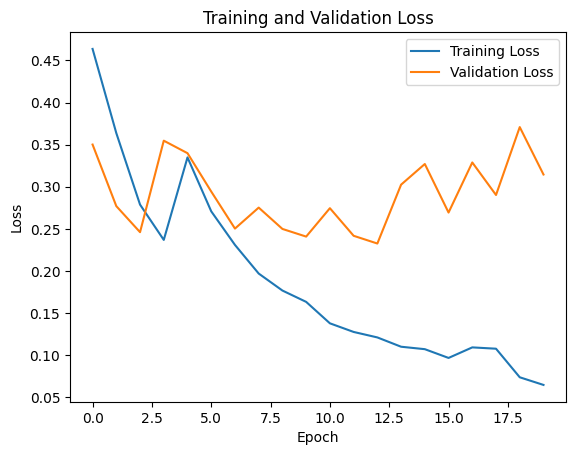

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
